<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#My-sample-from-dataset_train.parquet" data-toc-modified-id="My-sample-from-dataset_train.parquet-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>My sample from dataset_train.parquet</a></span></li><li><span><a href="#-Learning-CatBoost-Models-" data-toc-modified-id="-Learning-CatBoost-Models--3"><span class="toc-item-num">3&nbsp;&nbsp;</span> Learning CatBoost Models </a></span><ul class="toc-item"><li><span><a href="#Далее-общая-модель" data-toc-modified-id="Далее-общая-модель-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Далее общая модель</a></span></li></ul></li><li><span><a href="#List-of-true-features" data-toc-modified-id="List-of-true-features-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>List of true features</a></span></li></ul></div>

In [1]:
# Импортируем библиотеки
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

RANDOM_STATE = 180723
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score,\
recall_score, roc_curve, RocCurveDisplay, f1_score, roc_auc_score, r2_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# импорт библиотек Nikolay K
from lightgbm import LGBMClassifier
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)

In [3]:
# Make corr function
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

# Dooing downsample function
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

# Doing function for marking cat_features
cat = ['ctg', 'flg','channel_name','src_id']
def cat_columns(columns, cat):
    cat_columns = []
    for col in columns:
        for c in cat:
            if c in col:
                cat_columns.append(col)
    return cat_columns

In [4]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(5,130))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('Важность признака')
    plt.ylabel('Названия признаков')

In [50]:
a = ['channel_name',
 'materials_details_16_1_ctg',
 'basic_info_2_0_min',
 'basic_info_0_0_avg',
 'user_devices_30_1_cnt',
 'basic_info_1_0_max',
 'cities_2_0_ctg',
 'user_active_9_1_flg',
 'user_devices_24_1_cnt',
 'type_av_100_0_1_ctg',
 'info_house_10_0_ctg',
 'communication_availability_51_1_flg',
 'materials_details_15_1_ctg',
 'markers_904_1_cnt',
 'movix_app_visits_17_1_cnt',
 'campaigns_369_6_part',
 'markers_933_1_cnt',
 'user_active_23_0_dt',
 'campaigns_357_1_sum',
 'migrant_0_1_flg',
 'markers_925_1_cnt',
 'campaigns_41_6_part',
 'materials_details_21_1_num',
 'campaigns_315_1_sum',
 'agreement_type_0_0_ctg',
 'save_team_answers_21_1_cnt',
 'campaigns_359_1_sum',
 'campaigns_328_1_sum',
 'campaigns_281_1_part',
 'communication_availability_53_1_flg',
 'cities_1_0_ctg',
 'issues_11_6_sum',
 'markers_905_1_cnt',
 'materials_details_22_1_flg',
 'markers_895_1_cnt',
 'user_active_29_1_flg',
 'markers_807_1_cnt',
 'movix_app_visits_62_1_cnt',
 'social_dem_2_0_flg',
 'markers_858_1_cnt',
 'campaigns_40_3_part',
 'campaigns_364_1d6_part',
 'movix_app_visits_24_1_cnt',
 'campaigns_403_3d6_part',
 'user_active_27_0_dt',
 'spas_symptoms_agr_286_12_sum',
 'user_active_10_1_flg',
 'campaigns_324_1_part',
 'user_active_24_0_dt',
 'materials_details_19_1_dt']
nick = ['tariff_plans_4_1_num',
 'charges_details_12_1_sum',
 'payments_details_35_6_sum',
 'spas_symptoms_agr_7_6_sum',
 'markers_706_1_cnt',
 'payments_details_28_3_sumpct',
 'payments_details_27_1_sumpct',
 'payments_details_29_6_sumpct',
 'balance_details_0_1_num',
 'payments_details_49_6_avg',
 'payments_details_48_3_sum',
 'markers_346_1_cnt',
 'spas_symptoms_agr_18_6_std',
 'arpu_2_6_avg',
 'markers_349_1_cnt',
 'markers_323_1_cnt',
 'markers_476_1_cnt',
 'payments_details_23_3d6_avg',
 'markers_40_1_cnt',
 'markers_310_1_cnt',
 'markers_60_1_cnt',
 'markers_330_1_cnt',
 'markers_333_1_cnt',
 'payments_details_33_1_sum',
 'markers_334_1_cnt',
 'markers_772_1_cnt',
 'markers_59_1_cnt',
 'markers_242_1_cnt',
 'markers_387_1_cnt',
 'tariff_plans_5_1_num']

gleb = ['id','target','info_house_5_0_num',
 'area_0_0_num',
 'user_lifetime_3_0_dt',
 'info_house_6_0_num',
 'traffic_details_43_1_std',
 'spas_symptoms_agr_154_12_sum',
 'traffic_details_62_1_sum',
 'traffic_details_39_3d6_std',
 'traffic_details_47_3_sum',
 'tariff_plans_22_1_min',
 'traffic_details_68_6_sum',
 'traffic_details_9_3d6_part',
 'spas_symptoms_agr_105_12_std',
 'traffic_details_37_3_std',
 'traffic_details_44_1_sum',
 'traffic_details_35_1d6_std',
 'traffic_details_5_1d3_part',
 'traffic_details_33_1d3_std',
 'traffic_details_2_6_cnt',
 'spas_symptoms_agr_150_6_std',
 'traffic_details_31_1_std',
 'traffic_details_53_1_sum',
 'traffic_details_65_3_sum',
 'traffic_details_38_3d6_avg',
 'traffic_details_18_1d6_avg',
 'traffic_details_56_3_sum',
 'spas_symptoms_int_43_1_cnt',
 'traffic_details_26_3d6_sum',
 'traffic_details_15_1d3_avg',
 'traffic_details_10_6_cnt',
 'traffic_details_6_1d6_part',
 'traffic_details_17_1d3_sum',
 'spas_symptoms_agr_162_6_std',
 'traffic_details_11_6_part',
 'traffic_details_32_1d3_avg',
 'traffic_details_24_3d6_avg',
 'vas_details_24_1_meanpct',
 'spas_symptoms_agr_79_6_sum',
 'spas_symptoms_agr_161_6_avg',
 'spas_symptoms_int_92_1_cnt',
 'spas_symptoms_agr_214_12_sum',
 'movix_channels_55_3d6_avg',
 'spas_symptoms_agr_70_12_sum',
 'traffic_details_34_1d6_avg',
 'traffic_details_0_1_cnt',
 'vas_details_5_6_sum',
 'vas_details_26_6_meanpct',
 'spas_symptoms_agr_151_6_sum',
 'traffic_details_20_1d6_sum',
 'spas_symptoms_agr_114_6_std']
feature_s = nick + gleb + a
feature_s

['tariff_plans_4_1_num',
 'charges_details_12_1_sum',
 'payments_details_35_6_sum',
 'spas_symptoms_agr_7_6_sum',
 'markers_706_1_cnt',
 'payments_details_28_3_sumpct',
 'payments_details_27_1_sumpct',
 'payments_details_29_6_sumpct',
 'balance_details_0_1_num',
 'payments_details_49_6_avg',
 'payments_details_48_3_sum',
 'markers_346_1_cnt',
 'spas_symptoms_agr_18_6_std',
 'arpu_2_6_avg',
 'markers_349_1_cnt',
 'markers_323_1_cnt',
 'markers_476_1_cnt',
 'payments_details_23_3d6_avg',
 'markers_40_1_cnt',
 'markers_310_1_cnt',
 'markers_60_1_cnt',
 'markers_330_1_cnt',
 'markers_333_1_cnt',
 'payments_details_33_1_sum',
 'markers_334_1_cnt',
 'markers_772_1_cnt',
 'markers_59_1_cnt',
 'markers_242_1_cnt',
 'markers_387_1_cnt',
 'tariff_plans_5_1_num',
 'id',
 'target',
 'info_house_5_0_num',
 'area_0_0_num',
 'user_lifetime_3_0_dt',
 'info_house_6_0_num',
 'traffic_details_43_1_std',
 'spas_symptoms_agr_154_12_sum',
 'traffic_details_62_1_sum',
 'traffic_details_39_3d6_std',
 'traffic

In [51]:
len(feature_s)

132

In [52]:
def dubl_list(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]


In [53]:
feature_s = dubl_list(feature_s)

In [54]:
len(feature_s)

132

In [55]:
# Загрузим признаки
data_5 = pd.read_parquet('dataset_train.parquet', engine='fastparquet', columns=feature_s)

In [56]:
# Общая информация
data_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702086 entries, 0 to 702085
Columns: 132 entries, tariff_plans_4_1_num to materials_details_19_1_dt
dtypes: float64(115), int32(7), int64(6), int8(2), object(2)
memory usage: 678.9+ MB


In [57]:
# Выделим фичи и таргет
# Marking cat_features
cat_features = cat_columns(data_5, cat)
data_5[cat_features] = data_5[cat_features].astype('category')
data_5['materials_details_16_1_ctg'] = data_5['materials_details_16_1_ctg'].astype('float64')
features = data_5.drop(['id', 'target'], axis=1)
target = data_5['target']

In [58]:
features_downsampled_5, target_downsampled_5 = downsample(features, target, 0.1)

In [59]:
%time
cat_features = features_downsampled_5.select_dtypes(include='category').columns.to_list()
# Построим модель CatBoostClassifier

model_cat_down5 = CatBoostClassifier(loss_function="Logloss", verbose=False,\
                               cat_features=cat_features,\
                               eval_metric='AUC:hints=skip_train~false',\
                               random_state=RANDOM_STATE, auto_class_weights="SqrtBalanced") 

grid = {'learning_rate': [0.1,  0.15, 0.17],
        'depth': [4,6, 8],
        'l2_leaf_reg': [1, 3, 5, 7],
        'iterations': [200] }
grid_search_result = model_cat_down5.grid_search(grid,
                                       X=features_downsampled_5,
                                       y=target_downsampled_5,
                                       plot=True, cv=5)

CPU times: total: 0 ns
Wall time: 0 ns


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.766514031
bestIteration = 197

0:	loss: 0.7665140	best: 0.7665140 (0)	total: 17.7s	remaining: 10m 20s

bestTest = 0.7676164677
bestIteration = 199

1:	loss: 0.7676165	best: 0.7676165 (1)	total: 35.6s	remaining: 10m 5s

bestTest = 0.7656563771
bestIteration = 199

2:	loss: 0.7656564	best: 0.7676165 (1)	total: 53.7s	remaining: 9m 50s

bestTest = 0.7662951624
bestIteration = 192

3:	loss: 0.7662952	best: 0.7676165 (1)	total: 1m 11s	remaining: 9m 29s

bestTest = 0.7634029387
bestIteration = 180

4:	loss: 0.7634029	best: 0.7676165 (1)	total: 1m 29s	remaining: 9m 12s

bestTest = 0.7651087815
bestIteration = 165

5:	loss: 0.7651088	best: 0.7676165 (1)	total: 1m 47s	remaining: 8m 55s

bestTest = 0.7659285756
bestIteration = 180

6:	loss: 0.7659286	best: 0.7676165 (1)	total: 2m 4s	remaining: 8m 36s

bestTest = 0.7667422339
bestIteration = 190

7:	loss: 0.7667422	best: 0.7676165 (1)	total: 2m 22s	remaining: 8m 19s

bestTest = 0.7669474598
bestIteration = 196

8:	loss: 0.7669475	bes

In [60]:
# Средняя оценка на кросс-валидации

result_cat = pd.DataFrame(grid_search_result)
np.mean(result_cat.T['test-AUC-mean']['cv_results'])

0.7606793850300443

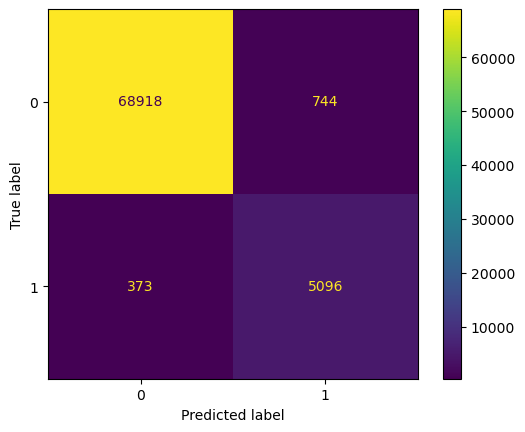

In [61]:
# Матрица ошибок
predicted_cat = model_cat_down5.predict(features_downsampled_5)

cm = confusion_matrix(target_downsampled_5, predicted_cat, labels=model_cat_down5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_cat_down5.classes_)
disp.plot()

plt.show()

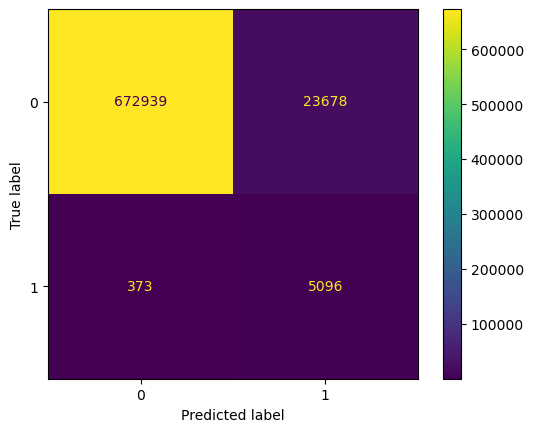

In [63]:
# Матрица ошибок
predicted_cat = model_cat_down5.predict(features)

cm = confusion_matrix(target, predicted_cat, labels=model_cat_down5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_cat_down5.classes_)
disp.plot()

plt.show()

In [64]:
feature_test = ['tariff_plans_4_1_num',
 'charges_details_12_1_sum',
 'payments_details_35_6_sum',
 'spas_symptoms_agr_7_6_sum',
 'markers_706_1_cnt',
 'payments_details_28_3_sumpct',
 'payments_details_27_1_sumpct',
 'payments_details_29_6_sumpct',
 'balance_details_0_1_num',
 'payments_details_49_6_avg',
 'payments_details_48_3_sum',
 'markers_346_1_cnt',
 'spas_symptoms_agr_18_6_std',
 'arpu_2_6_avg',
 'markers_349_1_cnt',
 'markers_323_1_cnt',
 'markers_476_1_cnt',
 'payments_details_23_3d6_avg',
 'markers_40_1_cnt',
 'markers_310_1_cnt',
 'markers_60_1_cnt',
 'markers_330_1_cnt',
 'markers_333_1_cnt',
 'payments_details_33_1_sum',
 'markers_334_1_cnt',
 'markers_772_1_cnt',
 'markers_59_1_cnt',
 'markers_242_1_cnt',
 'markers_387_1_cnt',
 'tariff_plans_5_1_num',
 'id',
 'info_house_5_0_num',
 'area_0_0_num',
 'user_lifetime_3_0_dt',
 'info_house_6_0_num',
 'traffic_details_43_1_std',
 'spas_symptoms_agr_154_12_sum',
 'traffic_details_62_1_sum',
 'traffic_details_39_3d6_std',
 'traffic_details_47_3_sum',
 'tariff_plans_22_1_min',
 'traffic_details_68_6_sum',
 'traffic_details_9_3d6_part',
 'spas_symptoms_agr_105_12_std',
 'traffic_details_37_3_std',
 'traffic_details_44_1_sum',
 'traffic_details_35_1d6_std',
 'traffic_details_5_1d3_part',
 'traffic_details_33_1d3_std',
 'traffic_details_2_6_cnt',
 'spas_symptoms_agr_150_6_std',
 'traffic_details_31_1_std',
 'traffic_details_53_1_sum',
 'traffic_details_65_3_sum',
 'traffic_details_38_3d6_avg',
 'traffic_details_18_1d6_avg',
 'traffic_details_56_3_sum',
 'spas_symptoms_int_43_1_cnt',
 'traffic_details_26_3d6_sum',
 'traffic_details_15_1d3_avg',
 'traffic_details_10_6_cnt',
 'traffic_details_6_1d6_part',
 'traffic_details_17_1d3_sum',
 'spas_symptoms_agr_162_6_std',
 'traffic_details_11_6_part',
 'traffic_details_32_1d3_avg',
 'traffic_details_24_3d6_avg',
 'vas_details_24_1_meanpct',
 'spas_symptoms_agr_79_6_sum',
 'spas_symptoms_agr_161_6_avg',
 'spas_symptoms_int_92_1_cnt',
 'spas_symptoms_agr_214_12_sum',
 'movix_channels_55_3d6_avg',
 'spas_symptoms_agr_70_12_sum',
 'traffic_details_34_1d6_avg',
 'traffic_details_0_1_cnt',
 'vas_details_5_6_sum',
 'vas_details_26_6_meanpct',
 'spas_symptoms_agr_151_6_sum',
 'traffic_details_20_1d6_sum',
 'spas_symptoms_agr_114_6_std',
 'channel_name',
 'materials_details_16_1_ctg',
 'basic_info_2_0_min',
 'basic_info_0_0_avg',
 'user_devices_30_1_cnt',
 'basic_info_1_0_max',
 'cities_2_0_ctg',
 'user_active_9_1_flg',
 'user_devices_24_1_cnt',
 'type_av_100_0_1_ctg',
 'info_house_10_0_ctg',
 'communication_availability_51_1_flg',
 'materials_details_15_1_ctg',
 'markers_904_1_cnt',
 'movix_app_visits_17_1_cnt',
 'campaigns_369_6_part',
 'markers_933_1_cnt',
 'user_active_23_0_dt',
 'campaigns_357_1_sum',
 'migrant_0_1_flg',
 'markers_925_1_cnt',
 'campaigns_41_6_part',
 'materials_details_21_1_num',
 'campaigns_315_1_sum',
 'agreement_type_0_0_ctg',
 'save_team_answers_21_1_cnt',
 'campaigns_359_1_sum',
 'campaigns_328_1_sum',
 'campaigns_281_1_part',
 'communication_availability_53_1_flg',
 'cities_1_0_ctg',
 'issues_11_6_sum',
 'markers_905_1_cnt',
 'materials_details_22_1_flg',
 'markers_895_1_cnt',
 'user_active_29_1_flg',
 'markers_807_1_cnt',
 'movix_app_visits_62_1_cnt',
 'social_dem_2_0_flg',
 'markers_858_1_cnt',
 'campaigns_40_3_part',
 'campaigns_364_1d6_part',
 'movix_app_visits_24_1_cnt',
 'campaigns_403_3d6_part',
 'user_active_27_0_dt',
 'spas_symptoms_agr_286_12_sum',
 'user_active_10_1_flg',
 'campaigns_324_1_part',
 'user_active_24_0_dt',
 'materials_details_19_1_dt']

In [65]:
# Загрузим признаки

data_test = pd.read_parquet('features_oot.parquet', engine='fastparquet', columns=feature_test)

In [66]:
# Выделим фичи и таргет
# Marking cat_features
cat_features = cat_columns(data_test, cat)
data_test[cat_features] = data_test[cat_features].astype('category')
data_test['materials_details_16_1_ctg'] = data_test['materials_details_16_1_ctg'].astype('float64')
features = data_test.drop(['id'], axis=1)


In [67]:
test_data = data_test['id']
test_data = test_data.reset_index()

In [68]:
probabilities_cat = model_cat_down5.predict_proba(features)

In [69]:
target_test = probabilities_cat[:,1]
target_test = pd.Series(target_test)

In [70]:
target_test

0        0.308576
1        0.342784
2        0.398547
3        0.261303
4        0.226394
           ...   
60656    0.362291
60657    0.296925
60658    0.417937
60659    0.335301
60660    0.062494
Length: 60661, dtype: float64

In [71]:
test_data = pd.concat([test_data, target_test], axis=1)

In [72]:
test_data

,index,id,0
0,0,1548227,0.308576
1,1,1173554,0.342784
2,2,1370450,0.398547
3,3,1254949,0.261303
4,4,1549365,0.226394
...,...,...,...
60656,60656,1510674,0.362291
60657,60657,1106063,0.296925
60658,60658,1396317,0.417937
60659,60659,1447072,0.335301


In [73]:
test_data = test_data.drop(['id'], axis=1)
test_data.columns = ['id', 'target']
test_data

,id,target
0,0,0.308576
1,1,0.342784
2,2,0.398547
3,3,0.261303
4,4,0.226394
...,...,...
60656,60656,0.362291
60657,60657,0.296925
60658,60658,0.417937
60659,60659,0.335301


In [74]:
test_data 

,id,target
0,0,0.308576
1,1,0.342784
2,2,0.398547
3,3,0.261303
4,4,0.226394
...,...,...
60656,60656,0.362291
60657,60657,0.296925
60658,60658,0.417937
60659,60659,0.335301


In [49]:
# Загрузим получившийся файл
test_data.to_csv('test_data.csv', index=False)